In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Set your dataset path here
dataset_path = '/content/drive/MyDrive/Garbage/TrashType_Image_Dataset'


In [3]:
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        image_count = len([img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.png', '.jpeg'))])
        print(f"{class_name}: {image_count} images")


cardboard: 403 images
metal: 410 images
.git: 0 images
plastic: 482 images
paper: 594 images
glass: 501 images
trash: 137 images


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 2024 images belonging to 7 classes.
Found 503 images belonging to 7 classes.


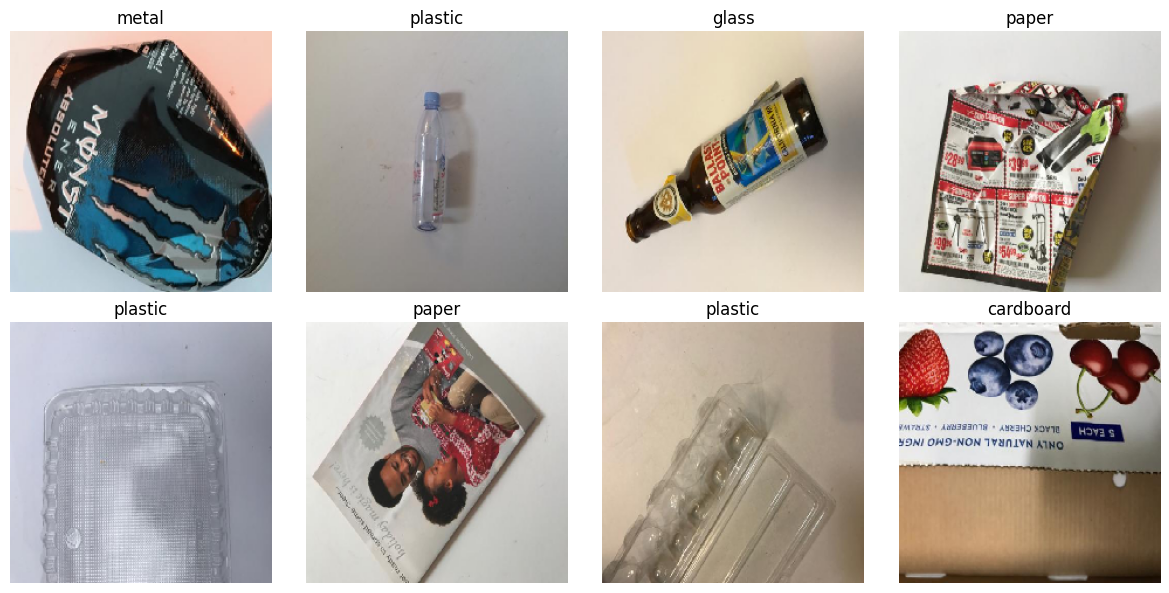

In [40]:
import matplotlib.pyplot as plt

class_labels = list(train_generator.class_indices.keys())

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_batch[i])
    plt.title(class_labels[np.argmax(y_batch[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [11]:
# ✅ Install required packages
!pip install -q tensorflow seaborn

# ✅ Imports
import os, glob, shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [12]:
# Dataset paths
original_data_dir = '/content/drive/MyDrive/Garbage/TrashType_Image_Dataset'
target_base_dir = '/content/garbage_data_balanced'

# Split dataset into train/val folders
if not os.path.exists(os.path.join(target_base_dir, 'train')):
    os.makedirs(os.path.join(target_base_dir, 'train'))
    os.makedirs(os.path.join(target_base_dir, 'val'))

    for class_name in os.listdir(original_data_dir):
        class_path = os.path.join(original_data_dir, class_name)
        if not os.path.isdir(class_path): continue
        images = glob.glob(os.path.join(class_path, "*.jpg"))
        if not images: continue
        train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

        for phase, imgs in zip(['train', 'val'], [train_imgs, val_imgs]):
            class_folder = os.path.join(target_base_dir, phase, class_name)
            os.makedirs(class_folder, exist_ok=True)
            for img in imgs:
                shutil.copy(img, class_folder)


In [13]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(target_base_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(target_base_dir, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(train_generator.class_indices.keys())
NUM_CLASSES = len(class_labels)


Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


In [14]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


In [16]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1),
    ModelCheckpoint("mobilenetv2_best_model.h5", save_best_only=True)
]


In [17]:
EPOCHS = 25

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.2403 - loss: 2.2244

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 638ms/step - accuracy: 0.2407 - loss: 2.2209 - val_accuracy: 0.3602 - val_loss: 1.5147 - learning_rate: 1.0000e-04
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.3371 - loss: 1.7132

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 471ms/step - accuracy: 0.3376 - loss: 1.7116 - val_accuracy: 0.5256 - val_loss: 1.2372 - learning_rate: 1.0000e-04
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.4474 - loss: 1.4462

64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 486ms/step - accuracy: 0.4478 - loss: 1.4452 - val_accuracy: 0.6063 - val_loss: 1.0772 - learning_rate: 1.0000e-04
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.5124 - loss: 1.2734

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 464ms/step - accuracy: 0.5125 - loss: 1.2733 - val_accuracy: 0.6457 - val_loss: 0.9868 - learning_rate: 1.0000e-04
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.5308 - loss: 1.2055

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 465ms/step - accuracy: 0.5311 - loss: 1.2050 - val_accuracy: 0.6791 - val_loss: 0.9055 - learning_rate: 1.0000e-04
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.5608 - loss: 1.1504

64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 497ms/step - accuracy: 0.5609 - loss: 1.1502 - val_accuracy: 0.6752 - val_loss: 0.8877 - learning_rate: 1.0000e-04
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.5705 - loss: 1.0821

64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 476ms/step - accuracy: 0.5706 - loss: 1.0822 - val_accuracy: 0.6988 - val_loss: 0.8213 - learning_rate: 1.0000e-04
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.6142 - loss: 1.0776

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 467ms/step - accuracy: 0.6141 - loss: 1.0771 - val_accuracy: 0.7126 - val_loss: 0.7918 - learning_rate: 1.0000e-04
Epoch 9/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6162 - loss: 1.0456

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 465ms/step - accuracy: 0.6164 - loss: 1.0449 - val_accuracy: 0.7323 - val_loss: 0.7524 - learning_rate: 1.0000e-04
Epoch 10/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 476ms/step - accuracy: 0.6444 - loss: 0.9701 - val_accuracy: 0.7244 - val_loss: 0.7537 - learning_rate: 1.0000e-04
Epoch 11/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.6129 - loss: 1.0277

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 466ms/step - accuracy: 0.6131 - loss: 1.0267 - val_accuracy: 0.7382 - val_loss: 0.7080 - learning_rate: 1.0000e-04
Epoch 12/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6398 - loss: 0.9699

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 461ms/step - accuracy: 0.6399 - loss: 0.9695 - val_accuracy: 0.7441 - val_loss: 0.7049 - learning_rate: 1.0000e-04
Epoch 13/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6523 - loss: 0.9250

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - accuracy: 0.6523 - loss: 0.9251 - val_accuracy: 0.7539 - val_loss: 0.6789 - learning_rate: 1.0000e-04
Epoch 14/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.6689 - loss: 0.8762

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - accuracy: 0.6688 - loss: 0.8765 - val_accuracy: 0.7520 - val_loss: 0.6743 - learning_rate: 1.0000e-04
Epoch 15/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.6698 - loss: 0.8774

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 462ms/step - accuracy: 0.6696 - loss: 0.8774 - val_accuracy: 0.7736 - val_loss: 0.6464 - learning_rate: 1.0000e-04
Epoch 16/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6776 - loss: 0.8874

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 462ms/step - accuracy: 0.6775 - loss: 0.8871 - val_accuracy: 0.7677 - val_loss: 0.6436 - learning_rate: 1.0000e-04
Epoch 17/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.6649 - loss: 0.8581

64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 477ms/step - accuracy: 0.6651 - loss: 0.8580 - val_accuracy: 0.7835 - val_loss: 0.6184 - learning_rate: 1.0000e-04
Epoch 18/25
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.6881 - loss: 0.8464

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 462ms/step - accuracy: 0.6884 - loss: 0.8450 - val_accuracy: 0.7815 - val_loss: 0.6126 - learning_rate: 1.0000e-04
Epoch 19/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - accuracy: 0.6834 - loss: 0.8325 - val_accuracy: 0.7815 - val_loss: 0.6193 - learning_rate: 1.0000e-04
Epoch 20/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7019 - loss: 0.8226

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 462ms/step - accuracy: 0.7018 - loss: 0.8227 - val_accuracy: 0.7913 - val_loss: 0.5759 - learning_rate: 1.0000e-04
Epoch 21/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - accuracy: 0.7147 - loss: 0.8399 - val_accuracy: 0.7913 - val_loss: 0.5880 - learning_rate: 1.0000e-04
Epoch 22/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.6910 - loss: 0.7929
Epoch 22: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 466ms/step - accuracy: 0.6910 - loss: 0.7935 - val_accuracy: 0.7815 - val_loss: 0.5963 - learning_rate: 1.0000e-04
Epoch 23/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 462ms/step - accuracy: 0.6736 - loss: 0.8173 - val_accuracy: 0.7894 - val_loss: 0.5817 - learning_rate: 3.0000e-05
Epoch 24/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.7204 - loss: 0.7515

64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.7204 - loss: 0.7519 - val_accuracy: 0.7913 - val_loss: 0.5696 - learning_rate: 3.0000e-05
Epoch 25/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.7110 - loss: 0.8042

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 468ms/step - accuracy: 0.7110 - loss: 0.8037 - val_accuracy: 0.7913 - val_loss: 0.5686 - learning_rate: 3.0000e-05


In [18]:
# Fine-tune top layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.4950 - loss: 1.3167

64/64 ━━━━━━━━━━━━━━━━━━━━ 67s 699ms/step - accuracy: 0.4953 - loss: 1.3161 - val_accuracy: 0.7913 - val_loss: 0.5569 - learning_rate: 1.0000e-05
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.5794 - loss: 1.1579

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 470ms/step - accuracy: 0.5793 - loss: 1.1575 - val_accuracy: 0.7953 - val_loss: 0.5503 - learning_rate: 1.0000e-05
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 462ms/step - accuracy: 0.5960 - loss: 1.0228 - val_accuracy: 0.7815 - val_loss: 0.5509 - learning_rate: 1.0000e-05
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.6258 - loss: 1.0025

64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 505ms/step - accuracy: 0.6259 - loss: 1.0022 - val_accuracy: 0.7835 - val_loss: 0.5490 - learning_rate: 1.0000e-05
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6516 - loss: 0.9698

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 472ms/step - accuracy: 0.6517 - loss: 0.9692 - val_accuracy: 0.7717 - val_loss: 0.5413 - learning_rate: 1.0000e-05
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.6750 - loss: 0.8671

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 471ms/step - accuracy: 0.6750 - loss: 0.8672 - val_accuracy: 0.7717 - val_loss: 0.5377 - learning_rate: 1.0000e-05
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 479ms/step - accuracy: 0.6793 - loss: 0.8662 - val_accuracy: 0.7697 - val_loss: 0.5418 - learning_rate: 1.0000e-05
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.6965 - loss: 0.8167

64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - accuracy: 0.6967 - loss: 0.8164 - val_accuracy: 0.7677 - val_loss: 0.5347 - learning_rate: 1.0000e-05
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 460ms/step - accuracy: 0.7026 - loss: 0.8019 - val_accuracy: 0.7657 - val_loss: 0.5348 - learning_rate: 1.0000e-05
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.7048 - loss: 0.8126
Epoch 10: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 496ms/step - accuracy: 0.7047 - loss: 0.8124 - val_accuracy: 0.7638 - val_loss: 0.5389 - learning_rate: 1.0000e-05


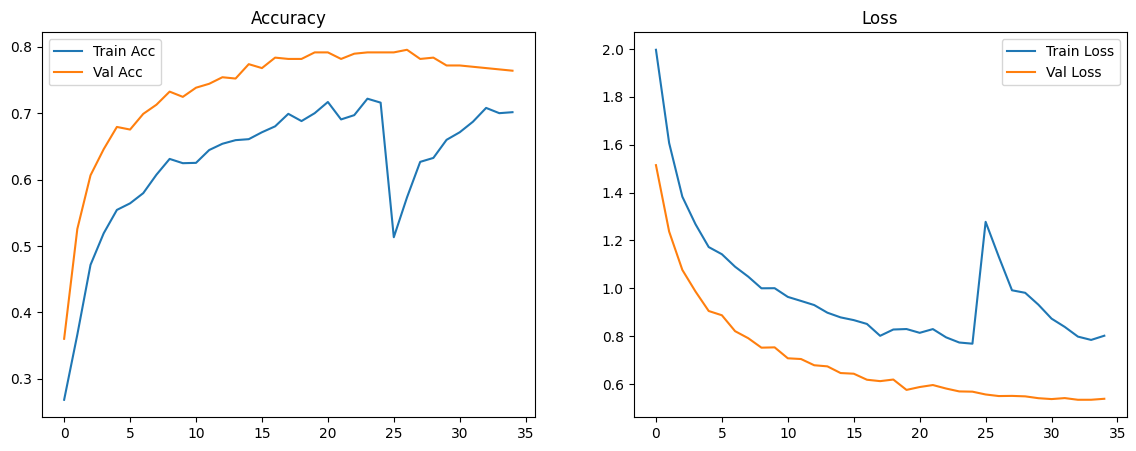

In [19]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_ft.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_ft.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_ft.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()


In [21]:
model.save("garbage_classifier_mobilenetv2_final.keras")  # ✅ Native Keras format


Saving glass12.jpg to glass12.jpg


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 60 variables whereas the saved optimizer has 118 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


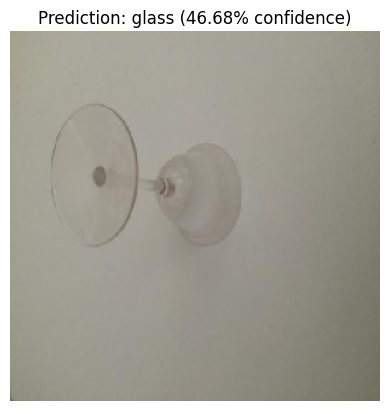

🧾 Predicted Class: glass
📊 Confidence: 46.68%


In [22]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
from IPython.display import display
from PIL import Image
import io
import matplotlib.pyplot as plt
from google.colab import files  # Use only in Colab

# Upload image
uploaded = files.upload()

# Get uploaded file path
img_path = next(iter(uploaded))  # First uploaded file

# Load model
from tensorflow.keras.models import load_model

model = load_model("garbage_classifier_mobilenetv2_final.keras")


# Class labels (must match your training classes)
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']  # ← Replace with actual classes

# Prediction function
def predict_image(img_path, model, class_labels):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0]
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = float(np.max(prediction)) * 100

    # Show image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f}% confidence)")
    plt.show()

    return predicted_class, confidence

# Predict and show result
predicted_class, accuracy = predict_image(img_path, model, class_labels)
print(f"🧾 Predicted Class: {predicted_class}")
print(f"📊 Confidence: {accuracy:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 313ms/step
📄 Classification Report:

              precision    recall  f1-score   support

   cardboard       0.96      0.89      0.92        81
       glass       0.73      0.57      0.64       101
       metal       0.83      0.73      0.78        82
       paper       0.93      0.82      0.87       119
     plastic       0.61      0.82      0.70        97
       trash       0.49      0.82      0.61        28

    accuracy                           0.77       508
   macro avg       0.76      0.78      0.76       508
weighted avg       0.80      0.77      0.77       508



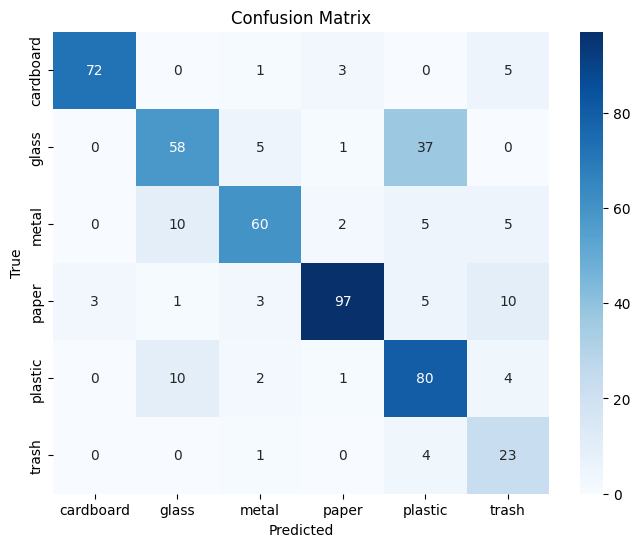

In [23]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

# Classification Report
print("📄 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [24]:
# Example: reload or rebuild the model first
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# After train_generator is created
NUM_CLASSES = len(train_generator.class_indices)

# Model building
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)


In [36]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"✅ Final Training Accuracy: {final_train_acc:.4f}")
print(f"✅ Final Validation Accuracy: {final_val_acc:.4f}")


✅ Final Training Accuracy: 0.8593
✅ Final Validation Accuracy: 0.8465


In [37]:
loss, accuracy = model.evaluate(val_generator)
print(f"✅ Final Evaluated Accuracy on Validation Set: {accuracy:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8570 - loss: 0.3745
✅ Final Evaluated Accuracy on Validation Set: 0.8465


In [38]:
loss, accuracy = model.evaluate(val_generator)
print(f"✅ Final Evaluated Accuracy on Validation Set: {accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8570 - loss: 0.3745
✅ Final Evaluated Accuracy on Validation Set: 0.8465
